In [5]:
import time
import nrrd
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
import h5py

from dipy.tracking.local import LocalTracking, ThresholdTissueClassifier
from dipy.tracking.utils import random_seeds_from_mask
from dipy.reconst.dti import TensorModel
from dipy.reconst.csdeconv import (ConstrainedSphericalDeconvModel,
                                   auto_response)
from dipy.reconst.shm import CsaOdfModel
from dipy.data import default_sphere
from dipy.direction import peaks_from_model
from dipy.data import fetch_stanford_hardi, read_stanford_hardi, get_sphere
from dipy.segment.mask import median_otsu
from dipy.viz import actor, window
from dipy.io.image import save_nifti
from dipy.io import read_bvals_bvecs
from dipy.core import gradients
from dipy.tracking.streamline import Streamlines
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table, gradient_table_from_bvals_bvecs
from dipy.reconst.dti import fractional_anisotropy

from dipy.tracking import utils

import src.dwi_tools as dwi_tools
import src.nn_helper as nn_helper

Using TensorFlow backend.


In [6]:
pTrainData_fibrePrediction = 'train_prediction_grid_normalized_dti_cs1_wholebrain.h5'
pTrainData_fibreTracking = 'train_tracking_grid_normalized_dti_cs1_wholebrain.h5'
pTrainInput = 'train_input_normalized_dti_cs1_wholebrain_'
noCrossings = 3

# Data Handling

load bvec/bval and compute gradient table

In [7]:
bvals, bvecs = read_bvals_bvecs('100307/bvals', '100307/bvecs')
gtab = gradient_table(bvals=bvals, bvecs=bvecs,b0_threshold=5)

In [8]:
img = nb.load('100307/data.nii.gz')
dwi = img.get_data()
aff = img.affine
img = nb.load('100307/T1w_acpc_dc_restore_1.25.nii.gz')
t1 = img.get_data()
binarymask, options = nrrd.read('100307/nodif_brain_mask.nrrd')

In [9]:
aff = np.eye(4,4)

visualize DWI data

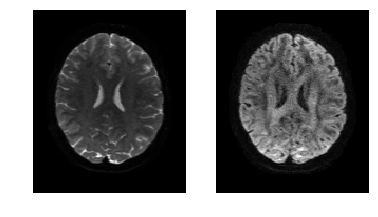

In [10]:
axial_middle = dwi.shape[2] // 2
plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(dwi[:, :, axial_middle, 0].T, cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(dwi[:, :, axial_middle, 10].T, cmap='gray', origin='lower')
plt.show()

# Tractography

In this section we'll generate streamlines using different approaches. This is gonna be the foundation for the evaluation of our method. We'll also employ simulated as well as curated data for our analysis.

In [11]:
# roi_idx = (slice(20, 50), slice(55, 85), slice(38, 39)) #  splenium of the corpus callosum
from dipy.tracking.utils import random_seeds_from_mask, seeds_from_mask
ccmask = np.zeros(binarymask.shape)
ccmask[20:50,55:85,38:39] = 1

In [12]:
ccseeds = seeds_from_mask(ccmask)

In [13]:
ccmask, options = nrrd.read('100307/100307-ccSegmentation.nrrd')
ccseeds = seeds_from_mask(ccmask, affine=aff)
ccseedsNoAffine = seeds_from_mask(ccmask)
validationSeeds = ccseeds[45:48]

Slicer/UKF Data

## Diffusion Tensor Imaging

compute fractional anisotropy and select seeds_count seeds per voxel with FA > 0.3

In [ ]:
import dipy.reconst.dti as dti
start_time = time.time()
dti_wls = dti.TensorModel(gtab)
fit_wls = dti_wls.fit(dwi)
FA = fit_wls.fa
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + 's')
#seeds = random_seeds_from_mask(FA > 0.5, seeds_count=1)

In [ ]:
sphere = get_sphere('symmetric724')
start_time = time.time()
dtipeaks = peaks_from_model(model=dti_wls,
                            data=dwi,
                            sphere=sphere,
                            relative_peak_threshold=.5,
                            min_separation_angle=25,
                            mask=binarymask,
                            return_odf=False,
                            parallel=True,
                            normalize_peaks=False,
                            nbr_processes=48
                           )
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + 's')

In [ ]:
classifier = ThresholdTissueClassifier(dtipeaks.gfa, .25)
streamlines_generator = LocalTracking(dtipeaks, classifier, ccseeds, np.identity(4), step_size=.1)
#streamlines_generator = LocalTracking(dtipeaks, classifier, ccseeds, aff, step_size=.1)
streamlines = Streamlines(streamlines_generator)
streamlines_filtered = dwi_tools.filterStreamlinesByLength(streamlines, 50)

In [ ]:
dwi_tools.visStreamlines(streamlines,t1,vol_slice_idx=40)
#dwi_tools.visStreamlines(streamlines_filtered,t1,vol_slice_idx=76)

## Q-ball Reconstruction

In [ ]:
csamodel = CsaOdfModel(gtab, 4)
sphere = get_sphere('symmetric724')
start_time = time.time()
csapeaks = peaks_from_model(model=csamodel,
                            data=dwi,
                            sphere=sphere,
                            relative_peak_threshold=.5,
                            min_separation_angle=25,
                            mask=binarymask,
                            return_odf=False,
                            parallel=True,
                            normalize_peaks=False)

GFA = csapeaks.gfa
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s / GFA.shape (%d, %d, %d)' % GFA.shape)

tracking

In [ ]:
classifier = ThresholdTissueClassifier(dtipeaks.gfa, .25)
streamlines_generator = LocalTracking(csapeaks, classifier, seeds, np.identity(4), step_size=.5)
streamlines = Streamlines(streamlines_generator)
streamlines_filtered = dwi_tools.filterStreamlinesByLength(streamlines, 50)

Visualisation

In [ ]:
dwi_tools.visStreamlines(streamlines,t1)
#dwi_tools.visStreamlines(streamlines_filtered,t1,vol_slice_idx=76)

## Constrained Spherical Deconvolution

Use in case of b = 2,500 – 3,000 s/mm² data

In [ ]:
response, ratio = auto_response(gtab, dwi, roi_radius=10, fa_thr=0.5)
print(response)
print(ratio)
csd_model = ConstrainedSphericalDeconvModel(gtab, response)
sphere = get_sphere('symmetric724')
start_time = time.time()
csd_peaks = peaks_from_model(model=csd_model,
                             data=dwi,
                             sphere=sphere,
                             mask=binarymask,
                             relative_peak_threshold=.5,
                             min_separation_angle=25,
                             parallel=True)
GFA = csd_peaks.gfa
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s / GFA.shape (%d, %d, %d)' % GFA.shape)

In [ ]:
classifier = ThresholdTissueClassifier(csd_peaks.gfa, .25)
streamlines_generator = LocalTracking(csd_peaks, classifier, ccseeds, np.identity(4), step_size=.5)
streamlines = Streamlines(streamlines_generator)
streamlines_filtered = dwi_tools.filterStreamlinesByLength(streamlines, 50)

Visualisation

In [ ]:
dwi_tools.visStreamlines(streamlines_filtered,t1)

### Store intermediate data

In [ ]:
np.save(pTrainInput + "_sl_filt.npy",streamlines_filtered)
np.save(pTrainInput + "_sl.npy",streamlines)
np.save(pTrainInput + "_seeds.npy",ccseeds)

# Generate Training data

In [14]:
streamlines_filtered = np.load(pTrainInput + "_sl_filt.npy")
streamlines = np.load(pTrainInput + "_sl.npy")

prepare training data for fibre direction network

In [43]:
avB0 = np.mean(dwi[:, :, :, gtab.b0s_mask],axis=3)

In [44]:
avB0 = avB0[:,:,:,None]

In [48]:
dwi_B0normalized = dwi / avB0 # normalize data.. typically averaging would be used however that would yield dwi values way above 1 (6.5)
dwi_B0normalized = dwi_B0normalized[:, :, :, ~gtab.b0s_mask]  # remove B0 scans from dataset
dwi_B0normalized[np.logical_not(np.isfinite(dwi_B0normalized))] = 0.

/home/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


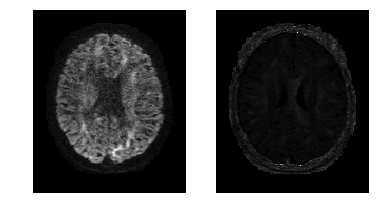

In [53]:
axial_middle = dwi.shape[2] // 2
plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(dwi[:, :, axial_middle, 50].T, cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(dwi_B0normalized[:, :, axial_middle, 50].T, cmap='gray', origin='lower')
plt.show()

In [17]:
noX = 8
noY = 8
noZ = 8
coordinateScaling = 1

In [58]:
import importlib
importlib.reload(dwi_tools)
#streamlines_filtered = np.asarray(np.load(pTrainInput + "_sl_filt.npy"))
#np.random.shuffle(streamlines_filtered)
import src.dwi_tools as dwi_tools
import src.nn_helper as nn_helper
start_time = time.time()
train_DWI,train_prevDirection, train_LikelyFibreDirections, train_nextDirection = dwi_tools.generatePredictionNetworkTrainingDataFromStreamlines(streamlines_filtered, dwi_B0normalized, noX=noX,noY=noY,noZ=noZ,coordinateScaling=coordinateScaling,distToNeighbours=1, noCrossings = noCrossings)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')

Generating training data
0/72027


/home/nico/Code/deepFibreTracking/src/dwi_tools.py:252: RuntimeWarning: invalid value encountered in true_divide
  train_X_2[streamlineIndex,] = np.nan_to_num(train_X_2[ctr,] / np.sqrt(np.sum(train_X_2[ctr,] ** 2))) # make unit vector


1000/72027
2000/72027
3000/72027
4000/72027
5000/72027
6000/72027
7000/72027
8000/72027
9000/72027
10000/72027
11000/72027
12000/72027
13000/72027
14000/72027
15000/72027
16000/72027
17000/72027
18000/72027
19000/72027
20000/72027
21000/72027
22000/72027
23000/72027
24000/72027
25000/72027
26000/72027
27000/72027
28000/72027
29000/72027
30000/72027
31000/72027
32000/72027
33000/72027
34000/72027
35000/72027
36000/72027
37000/72027
38000/72027
39000/72027
40000/72027
41000/72027
42000/72027
43000/72027
44000/72027
45000/72027
46000/72027
47000/72027
48000/72027
49000/72027
50000/72027
51000/72027
52000/72027
53000/72027
54000/72027
55000/72027
56000/72027
57000/72027
58000/72027
59000/72027
60000/72027
61000/72027
62000/72027
63000/72027
64000/72027
65000/72027
66000/72027
67000/72027
68000/72027
69000/72027
70000/72027
71000/72027
72000/72027
Runtime 913.533510684967 s 


/home/nico/Code/deepFibreTracking/src/dwi_tools.py:250: RuntimeWarning: invalid value encountered in true_divide
  train_Y_2[streamlineIndex,] = np.nan_to_num(train_Y_2[ctr,] / np.sqrt(np.sum(train_Y_2[ctr,] ** 2))) # make unit vector


In [26]:
with h5py.File(pTrainData_fibrePrediction+'norm',"w") as f:
    f.create_dataset('train_DWI',data=train_DWI)
    f.create_dataset('train_curPosition',data=train_prevDirection)   
    f.create_dataset('train_LikelyFibreDirections',data=train_LikelyFibreDirections)   
    f.create_dataset('train_NextFibreDirection',data=train_nextDirection)   

## Training

In [59]:
noGPUs = 3
batch_size = 2**8
batch_size -= batch_size % noGPUs # make batch size divisible by no. of GPUs
epochs = 50

In [15]:
f = h5py.File(pTrainData_fibrePrediction, "r")
train_DWI = np.array(f["train_DWI"].value)
train_prevDirection = np.array(f["train_curPosition"].value)
train_likelyDirections = np.array(f["train_LikelyFibreDirections"].value)
train_nextDirection = np.array(f["train_NextFibreDirection"].value)
f.close()
#train_lastDirection = np.expand_dims(train_lastDirection, axis=1)

### data normalization

In [ ]:
#train_LikelyFibreDirections = (train_LikelyFibreDirections + 1) / 2
#train_lastDirection = (train_lastDirection + 1) / 2
#train_DWI = nn_helper.normalizeDWI(train_DWI)
##train_lastDirection_unit = nn_helper.normalizeStreamlineOrientation(train_lastDirection)
##train_NextFibreDirection_unit = nn_helper.normalizeStreamlineOrientation(train_NextFibreDirection)

## MLP / Bidirectional

simple

In [ ]:
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Activation
import importlib
importlib.reload(nn_helper)
from keras.callbacks import TensorBoard
mlp_simple_newNormalisation = nn_helper.get_mlp_simpleTracker(activation_function = LeakyReLU(), features = 512, inputShapeDWI=train_DWI.shape[1:5],depth = 3, noGPUs=noGPUs)
mlp_simple_newNormalisation.fit([train_DWI], [train_prevDirection,train_nextDirection], batch_size=batch_size, epochs=10, verbose=1,validation_split=0.2, callbacks=[])

advanced

In [ ]:
from keras.layers.advanced_activations import LeakyReLU

import importlib
importlib.reload(nn_helper)
from keras.callbacks import TensorBoard
mlp_adv = nn_helper.get_mlp_advancedTracker(activation_function = Activation('tanh'), features = 512, inputShapeDWI=(noX, noY, noZ, 270),depth = 3, noGPUs=noGPUs, inputShapeStreamline=(3,1))
#mlp_adv.summary()
mlp_adv.fit([train_DWI,train_prevDirection], [train_NextFibreDirection], batch_size=batch_size, epochs=100, verbose=1,validation_split=0.2, callbacks=[])

### UNET / Bidirectional

In [ ]:
import src.nn_helper as nn_helper
importlib.reload(nn_helper)
unet_tracker = nn_helper.get_3Dunet_simpleTracker(activation_function = LeakyReLU(), inputShapeDWI=train_DWI.shape[1:5], depth = 3, noGPUs=noGPUs)
unet_tracker.fit([train_DWI], [train_prevDirection,train_nextDirection], batch_size=batch_size, epochs=10, verbose=1,validation_split=0.2, callbacks=[])

Train on 57621 samples, validate on 14406 samples
Epoch 1/10
 1275/57621 [..............................] - ETA: 3:22 - loss: -0.2969 - prevDirection_loss: -0.1426 - nextDirection_loss: -0.1543

no batch normalisation

In [ ]:
from keras import backend as K

def relu_advanced(x):
    return K.relu(x, max_value=1)

In [ ]:
import importlib
import keras
import src.nn_helper as nn_helper
importlib.reload(nn_helper)
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
pModel = "tractography_model_{epoch:02d}-{val_loss:.6f}.h5"
#unet_tracker_2 = nn_helper.get_3Dunet_simpleTracker(activation_function = keras.layers.core.Activation('relu'), inputShapeDWI=(noX, noY, noZ, 270),depth = 3, noGPUs=noGPUs)
unet_tracker_2 = nn_helper.get_3Dunet_simpleTracker(activation_function = LeakyReLU(), inputShapeDWI=(noX, noY, noZ, 270),depth = 3, noGPUs=noGPUs)
csv_logger = CSVLogger("tractography_log.csv")
checkpoint = ModelCheckpoint(pModel, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list=[checkpoint, csv_logger]
unet_tracker_2.fit([train_DWI], [train_NextFibreDirection], batch_size=batch_size, epochs=100, verbose=1, validation_split=0.2, callbacks=[])

# DEBUG TRACKING

In [43]:
noX = 16
noY = 16
noZ = 16

In [44]:
import dipy.align.vector_fields as vfu
import tensorflow as tf
validationSeeds = ccseeds[0:1]
x_ = coordinateScaling * np.linspace(-8., 8., noX)
y_ = coordinateScaling * np.linspace(-8., 8., noY)
z_ = coordinateScaling * np.linspace(-8., 8., noZ)    
z_ = 1
noZ = 1

In [45]:
noSeeds = len(validationSeeds)
noIterations = 1000
dw = 270

In [46]:
streamlinePositions = np.zeros([noSeeds,noIterations+1,3])
streamlinePositions[:,0,] = validationSeeds[0:noSeeds]
streamlinePositions[:,1,] = validationSeeds[0:noSeeds]
x = np.zeros([noSeeds,noX,noY,noZ,dw])
iter = 1

In [48]:
streamlinePositions[0,iter,]

array([70., 68., 61.])

In [145]:
data=dwi_B0normalized
#model=msd_simple

In [150]:
for j in range(0,noSeeds):
    coordVecs = np.vstack(np.meshgrid(x_,y_,z_, indexing='ij')).reshape(3,-1).T + streamlinePositions[j,iter,]
    for i in range(0,dw):
        x[j,:,:,:,i] = np.reshape(vfu.interpolate_scalar_3d(data[:,:,:,i],coordVecs)[0], [noX,noY,noZ])

In [120]:
coordVecs[0]

array([66., 64., 62.])

In [121]:
coordVecs[1]

array([66.        , 65.14285714, 62.        ])

In [138]:
coordVecs[0]

array([62., 60., 62.])

In [139]:
coordVecs[-1]

array([78., 76., 62.])

In [35]:
streamlinePositions

array([[[70., 68., 61.],
        [70., 68., 61.],
        [ 0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]]])

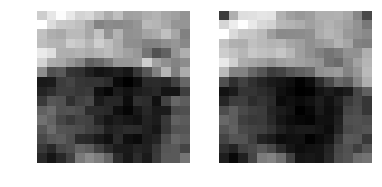

In [151]:
axial_middle = dwi.shape[2] // 2
plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(data[62:78, 60:76, 62, 10].T, cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(x[0,:,:,0,10].T, cmap='gray', origin='lower')
plt.show()

In [33]:
x.shape

(1, 8, 8, 8, 270)

In [81]:
data.shape

(145, 174, 145, 270)

In [ ]:
with tf.device('/cpu:0'):
    y2 = msd_simple.predict([x])
    #y3 = unet_tracker_2.predict([train_DWI[0:1,]])

In [ ]:
y2

In [ ]:
y2

In [ ]:
train_NextFibreDirection_unit[0]

In [ ]:
import keras
import keras.backend as K
keras.losses.mse(y,np.float32(train_NextFibreDirection_unit[0])).eval(session=K.get_session())

In [ ]:
from numpy import (array, dot, arccos, clip) 
from numpy.linalg import norm 

u = y
v = train_NextFibreDirection[0]
c = dot(u,v)/norm(u)/norm(v)
angle = arccos(clip(c, -1, 1)) 
angle

In [ ]:
u = nn_helper.denormalizeStreamlineOrientation(u)
v = nn_helper.denormalizeStreamlineOrientation(v)
c = dot(u,v)/norm(u)/norm(v)
angle = arccos(clip(c, -1, 1)) 
c

In [ ]:
yy = y / np.sqrt(np.sum(y ** 2))
yy

In [ ]:
vv = v / np.sqrt(np.sum(v ** 2))
vv

# Tracking

In [ ]:
classifier = ThresholdTissueClassifier(dtipeaks.gfa, .25)
streamlines_generator = LocalTracking(dtipeaks, classifier, validationSeeds, np.identity(4), step_size=.1)
#streamlines_generator = LocalTracking(dtipeaks, classifier, ccseeds, aff, step_size=.1)
streamlines_val = Streamlines(streamlines_generator)
streamlines_filtered_val = dwi_tools.filterStreamlinesByLength(streamlines, 50)

## MLP/Bidirectional Tracker

In [ ]:
validationSeeds

In [61]:
import src.tracking as tracking
importlib.reload(tracking)
start_time = time.time()
streamlines_mlp_simple = tracking.applySimpleTrackerNetwork(seeds=validationSeeds,data=dwi_B0normalized, model=mlp_simple_newNormalisation, nnOutputToUse = 0, noX=noX, noY=noY, noZ=noZ, dw = 270, stepWidth = 0.1, coordinateScaling = coordinateScaling)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')
import src.tracking as tracking
importlib.reload(tracking)
start_time = time.time()
streamlines_mlp_simple_2 = tracking.applySimpleTrackerNetwork(seeds=validationSeeds,data=dwi_B0normalized, model=mlp_simple_newNormalisation, nnOutputToUse = 1, noX=noX, noY=noY, noZ=noZ, dw = 270, stepWidth = 0.1, coordinateScaling = coordinateScaling)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')
streamlines_mlp_simple_f = np.fliplr(streamlines_mlp_simple)
streamlines_joined = np.concatenate([streamlines_mlp_simple_f,streamlines_mlp_simple_2],axis=1)

Runtime 62.127015590667725 s 
Runtime 61.150097131729126 s 


In [65]:
import src.dwi_tools as dwi_tools
importlib.reload(dwi_tools)
dwi_tools.visTwoSetsOfStreamlines(streamlines_val,streamlines_joined,t1[:,:,:], vol_slice_idx = 75, vol_slice_idx2 = 55)
#dwi_tools.visStreamlines(streamlines_val,t1, vol_slice_idx = 73)

/home/nico/anaconda3/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [ ]:
np.save('streamlines_validation.npy', streamlines_val)

In [64]:
streamlines_val = np.load('streamlines_validation.npy')

## MSD/Simple Network

In [ ]:
import src.tracking as tracking
importlib.reload(tracking)
start_time = time.time()
streamlines_msd_simple = tracking.applySimpleTrackerNetwork(seeds=[ccseeds[0:100]],data=dwi_B0normalized, model=msd_simple, noX=noX, noY=noY, noZ=noZ, dw = 270, stepWidth = 0.1, coordinateScaling = coordinateScaling)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')

In [ ]:
streamlines_msd_simple[0,5,:]

In [ ]:
streamlines_msd_simple[0,6,:]

In [ ]:
import src.dwi_tools as dwi_tools
importlib.reload(dwi_tools)
dwi_tools.visStreamlines(streamlines_msd_simple,t1, vol_slice_idx = 73)

### MSD/Advanced Tracking Network

In [ ]:
start_time = time.time()
streamlines_msd_adv = tracking.applyTrackerNetwork(seeds=ccseeds,data=dwi, model=msd, noX=noX, noY=noY, noZ=noZ, coordinateScaling=coordinateScaling)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')

In [ ]:
dwi_tools.visStreamlines(streamlines_msd_adv,t1, vol_slice_idx = 73)

### UNET/Advanced Tracking Network

In [ ]:
start_time = time.time()
streamlines = tracking.applySimpleTrackerNetwork(seeds=ccseeds,data=dwi, model=unet_tracker_2, noX=noX, noY=noY, noZ=noZ, coordinateScaling=coordinateScaling)
runtime = time.time() - start_time
print('Runtime ' + str(runtime) + ' s ')

In [ ]:
dwi_tools.visStreamlines(streamlines,t1, vol_slice_idx = 73)